In [1]:
import os
import sys
import json
import math
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
from DiffNet.datasets.single_instances.rectangles import RectangleManufactured

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42


In [2]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)
        x = np.linspace(0,1,self.domain_size)
        y = np.linspace(0,1,self.domain_size)
        xx, yy = np.meshgrid(x,y)
        self.u_exact = torch.tensor(self.exact_solution(xx,yy))

    def exact_solution(self, x,y):
        return np.sin(math.pi*x)*np.sin(math.pi*y)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)


        nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        res_elmwise = transformation_jacobian * ((0.5 * nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp)))
        res_elmwise = torch.sum(res_elmwise, 1) 

        loss = torch.mean(res_elmwise)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        return self.network[0], inputs_tensor, forcing_tensor

    def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate
        opts = [torch.optim.LBFGS(self.network, lr=1.0, max_iter=5)]
        return opts, []
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), 
                                                         forcing.unsqueeze(0).type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # process u (by adding BC)
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)        
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        plt.show()
        # plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        # plt.close('all')        

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u, k, f = self.do_query(inputs, forcing)                
        
        u_exact = self.u_exact.squeeze().detach().cpu()
        diff = u - u_exact
        
        self.plot_contours(k,f,u,u_exact)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./manufactured/version_11 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 1.0 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
1.0 K     Trainable params
96        Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 0:   5%|▌         | 5/100 [00:00<00:03, 30.83it/s, loss=-3.66, v_num=1_11]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0: 100%|██████████| 100/100 [00:01<00:00, 93.40it/s, loss=-9.83, v_num=1_11]

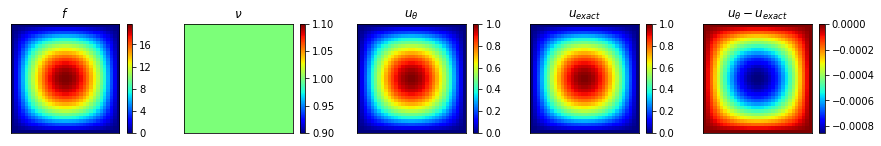

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 108.90it/s, loss=-9.83, v_num=1_11]

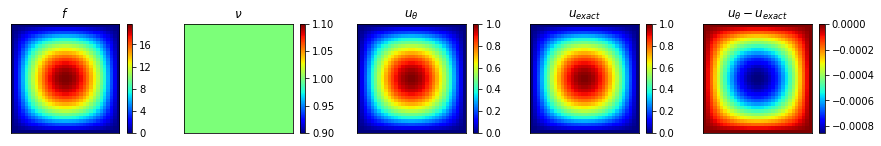

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 67.02it/s, loss=-9.83, v_num=1_11] 

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  6.7333         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.6756         	|2              	|  3.3511         	|  49.77          	|
run_training_batch                 	|  0.0078135      	|200            	|  1.5627         	|  23.209         	|
optimizer_step_and_closure_0       	|  0.0075683      	|200            	|  1.5137         	|  22.48          	|
on_epoch_end                       	|  0.67909        	|2              	|  1.3582         	|  20.171         	|
training_step_and_backward         

In [3]:
domain_size = 32

u_tensor = np.ones((1,1,domain_size,domain_size))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
dataset = RectangleManufactured(domain_size=domain_size)
basecase = Poisson(network, dataset, batch_size=1, domain_size=domain_size, learning_rate=0.01)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="manufactured")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=2, deterministic=True, profiler="simple")

# ------------------------
# 4 Training
# ------------------------

trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

J =  0.0002601456815816857
usol.shape = (32, 32)
uex.shape = (32, 32)
||u_sol||, ||uex|| =  0.49871736417064494 0.5
||e||_{{L2}} =  0.00128269008833109
||e|| (vector-norm) =  0.00041487261600942267


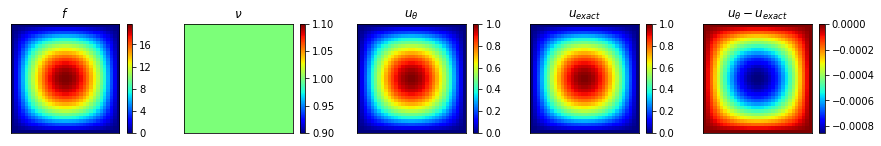

In [4]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, k, f = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze().detach().cpu()
# L2 error calculation
basecase.calc_l2_err(u.numpy())
# plot
basecase.plot_contours(k,f,u,u_exact)